# One-dimensional Lagrange Interpolation

The problem of interpolation or finding the value of a function at an arbitrary point $X$ inside a given domain, provided we have discrete known values of the function inside the same domain is at the heart of the finite element method. In this notebooke we use Lagrange interpolation where the approximation $\hat f(x)$ to the function $f(x)$ is built like:

\begin{equation}
\hat f(x)={L^I}(x)f^I
\end{equation}

In the expression above $L^I$ represents the $I$ Lagrange Polynomial of order $n-1$ and $f^1, f^2,,...,f^n$ are the $n$ known values of the function. Here we are using the summation convention over the repeated superscripts.

The $I$ Lagrange polynomial is given by the recursive expression:

\begin{equation}
{L^I}(x)=\prod_{J=1, J \ne I}^{n}{\frac{{\left( {x - {x^J}} \right)}}{{\left( {{x^I} - {x^J}} \right)}}} 
\end{equation}

in the domain $x\in[-1.0,1.0]$.

We wish to interpolate the function $ f(x)=x^3+4x^2-10 $ assuming we know its value at points $x=-1.0$, $x=1.0$ and $x=0.0$.

In [1]:
#from __future__ import division
import numpy as np
from scipy import interpolate
import sympy as sym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib notebook


First we use a function to generate the Lagrage polynomial of order $order$ at point $i$

In [3]:
def basis_lagrange(x_data, var, cont):
    """Find the basis for the Lagrange interpolant"""
    prod = sym.prod((var - x_data[i])/(x_data[cont] - x_data[i])
                    for i in range(len(x_data)) if i != cont)
    return sym.simplify(prod)

we now define the function $ f(x)=x^3+4x^2-10 $:

In [4]:
fun = lambda x: x**3 + 4*x**2 - 10

In [5]:
x = sym.symbols('x')
x_data = np.array([-1, 1, 0])
f_data = fun(x_data)

And obtain the Lagrange polynomials using:


In [6]:
basis = []
for cont in range(len(x_data)):
    basis.append(basis_lagrange(x_data, x, cont))
    sym.pprint(basis[cont])


x⋅(x - 1)
─────────
    2    
x⋅(x + 1)
─────────
    2    
   2    
- x  + 1


which are shown in the following plots/

In [7]:
npts = 101
x_eval = np.linspace(-1, 1, npts)
basis_num = sym.lambdify((x), basis, "numpy")  # Create a lambda function for the polynomials

<IPython.core.display.Javascript object>


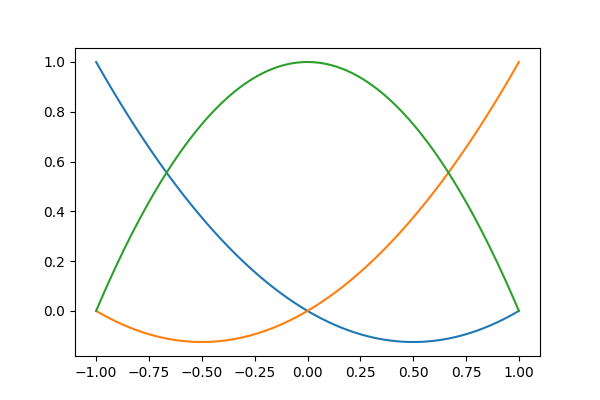

In [8]:
plt.figure(figsize=(6, 4))
for k in range(3):    
    y_eval = basis_num(x_eval)[k]
    plt.plot(x_eval, y_eval)

In [9]:
y_interp = sym.simplify(sum(f_data[k]*basis[k] for k in range(3)))
y_interp

4*x**2 + x - 10

Now we plot the complete approximating polynomial, the actual function and the points where the function was known.

<IPython.core.display.Javascript object>


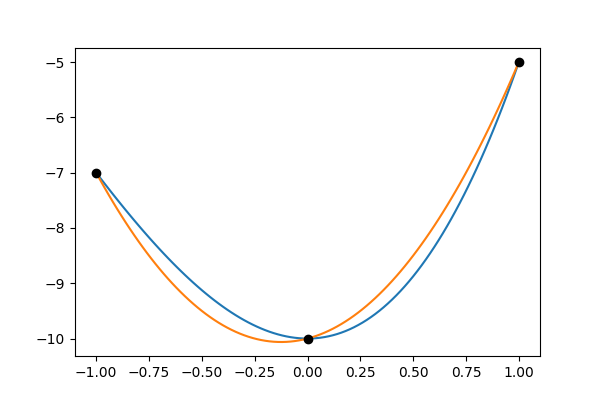

In [10]:
y_interp = sum(f_data[k]*basis_num(x_eval)[k] for k in range(3))
y_original = fun(x_eval)

plt.figure(figsize=(6, 4))
plt.plot(x_eval, y_original)
plt.plot(x_eval, y_interp)
plt.plot([-1, 1, 0], f_data, 'ko')
plt.show()

## Interpolation in 2 dimensions

We can extend the concept of Lagrange interpolation to 2 or more dimensions.
In the case of bilinear interpolation (2×2, 4 vertices) in $[-1, 1]^2$,
the base functions are given by (**prove it**):

\begin{align}
N_0 = \frac{1}{4}(1 - x)(1 - y)\\
N_1 = \frac{1}{4}(1 + x)(1 - y)\\
N_2 = \frac{1}{4}(1 + x)(1 + y)\\
N_3 = \frac{1}{4}(1 - x)(1 + y)
\end{align}

Let's see an example using piecewise bilinear interpolation.

In [11]:
def rect_grid(Lx, Ly, nx, ny):
    u"""Create a rectilinear grid for a rectangle
    
    The rectangle has dimensiones Lx by Ly. nx are 
    the number of nodes in x, and ny are the number of nodes
    in y
    """
    y, x = np.mgrid[-Ly/2:Ly/2:ny*1j, -Lx/2:Lx/2:nx*1j]
    els = np.zeros(((nx - 1)*(ny - 1), 4), dtype=int)
    for row in range(ny - 1):
        for col in range(nx - 1):
            cont = row*(nx - 1) + col
            els[cont, :] = [cont + row, cont + row + 1,
                              cont + row + nx + 1, cont + row + nx]
    return x.flatten(), y.flatten(), els

In [12]:
def interp_bilinear(coords, f_vals, grid=(10, 10)):
    """Piecewise bilinear interpolation for rectangular domains"""
    x_min, y_min = np.min(coords, axis=0)
    x_max, y_max = np.max(coords, axis=0)
    x, y = np.mgrid[-1:1:grid[0]*1j,-1:1:grid[1]*1j]
    N0 = (1 - x) * (1 - y)
    N1 = (1 + x) * (1 - y)
    N2 = (1 + x) * (1 + y)
    N3 = (1 - x) * (1 + y)
    interp_fun = N0 * f_vals[0] + N1 * f_vals[1] + N2 * f_vals[2] + N3 * f_vals[3]
    interp_fun = 0.25*interp_fun
    x, y = np.mgrid[x_min:x_max:grid[0]*1j, y_min:y_max:grid[1]*1j]
    return x, y, interp_fun

In [13]:
def fun(x, y):
    """Monkey saddle function"""
    return y**3 +  3*y*x**2

In [14]:
x_coords, y_coords, els = rect_grid(2, 2, 4, 4)
nels = els.shape[0]
z_coords = fun(x_coords, y_coords)
z_min = np.min(z_coords)
z_max = np.max(z_coords)

<IPython.core.display.Javascript object>


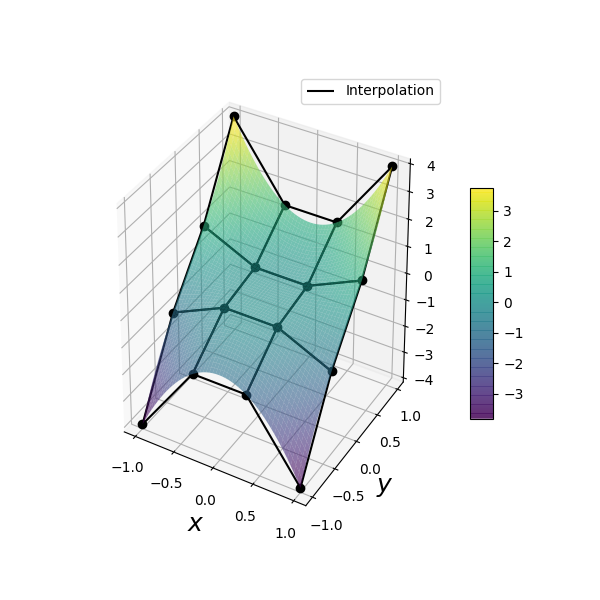

In [15]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
x, y = np.mgrid[-1:1:51j,-1:1:51j]
z = fun(x, y)
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, linewidth=0, alpha=0.6,
                      cmap="viridis")
plt.colorbar(surf, shrink=0.5, aspect=10)
ax.plot(x_coords, y_coords, z_coords, 'ok')
for k in range(nels):
    x_vals = x_coords[els[k, :]]
    y_vals = y_coords[els[k, :]]
    coords = np.column_stack([x_vals, y_vals])
    f_vals = fun(x_vals, y_vals)
    x, y, z = interp_bilinear(coords, f_vals, grid=[4, 4])
    inter = ax.plot_wireframe(x, y, z, color="black", cstride=3, rstride=3)
plt.xlabel(r"$x$", fontsize=18)
plt.ylabel(r"$y$", fontsize=18)
ax.legend([inter], [u"Interpolation"])
plt.show();

<sub>The next cell change the format of the Notebook.</sub>

In [34]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./styles/custom_barba.css', 'r').read()
    return HTML(styles)
css_styling()